In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import math
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import ecg
import hrv

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)  
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

def palette(LED):
    if LED == 'G':
        c = 'green'
    elif LED == 'R':
        c = '#E24A33'
    else:
        c = '#348ABD'
    return c 


def quality_inspection(filt_ppg, sr, pulse_loc, xcorr_thr=0.8):
    num_pulse = len(pulse_loc)
    hq_idx = np.zeros(num_pulse)
    r = np.zeros(num_pulse)
    duration = np.zeros(num_pulse)
    for n in range(num_pulse):
        tr1_loc = pulse_loc[n][0]
        tr2_loc = pulse_loc[n][2]
        duration[n] = tr2_loc- tr1_loc
    
    # Dynamic set the length of template
    template_length = int(np.median(duration))
    max_len = 180/60 # minimum HR 240
    min_len = 50/60 # minimum HR 40
    if template_length > sr*max_len:
        template_length = int(sr*max_len)
    elif template_length < sr*min_len:
        template_length = int(sr*min_len)
    # Template Initial
    tm_set = []
    fix_pulse_set = np.zeros((num_pulse, template_length))
    for n in range(num_pulse):
        single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)
        fix_pulse_set[n] = single_pulse
        
        if n == 0:
            ref_pulse = single_pulse
        else:
            test_pulse = single_pulse
        
            # Pulse similarity inspection using cross correlation 
            xcorr = sp.corrcoef(test_pulse, ref_pulse)
            r[n] = xcorr
            # Store the index of good quality pulse
            if xcorr > xcorr_thr:
                tm_set.append(test_pulse)       
                hq_idx[n] = 1
                
            # update previous pulse
            ref_pulse = test_pulse   
    
    return hq_idx, r

def correct_nni(pulse_loc, hq_idx):
    right_interval = []
    for j in range(1, len(pulse_loc)):
        if hq_idx[j-1] == 1 and hq_idx[j] == 1:
            pre_interval = pulse_loc[j-1][2] - pulse_loc[j-1][1]
            next_interval = pulse_loc[j][1] - pulse_loc[j][0]
            interval = pre_interval + next_interval
            right_interval.append(interval)
        
    nni_correct = (np.array(right_interval)/sr)*1000
    nni_correct[np.abs(sp.z_score(nni_correct)) > 2] = np.median(nni_correct)
    return nni_correct


def pulse_seg(ppg_peak_loc, ppg_valley_loc):
    pulse_loc_set = []
    for j in range(1, len(ppg_valley_loc)):
        # find single periodic wave
        v1 = ppg_valley_loc[j-1]
        v2 = ppg_valley_loc[j]

        pks_loc = []
        # extract single pulse
        for k, loc in enumerate(ppg_peak_loc):
            if loc > v1 and loc < v2:
                pk = ppg_peak_loc[k]
                pulse_loc_set.append([v1, pk, v2])
                break

    return pulse_loc_set

def local_max(data, peak_loc, w=8):
    peak_loc_len = len(peak_loc)
    modify_peak = np.zeros(peak_loc_len)
    for i in range(len(peak_loc)):
        loc = peak_loc[i]
        left_pt= max(0, loc-w)
        right_pt = min(len(data), loc+w)
        modify_peak[i] = left_pt + np.argmax(data[left_pt: right_pt])
    modify_peak = [int(v) for v in modify_peak]
    return modify_peak

# Check multiple file

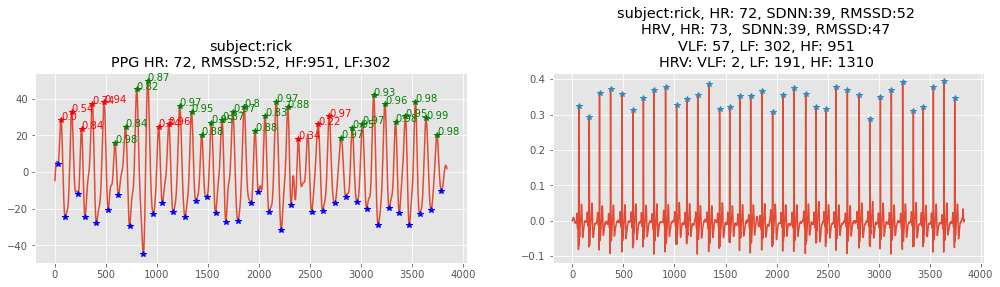

In [5]:


#new format, all data in one package
# folder = 'test/new_format'
# subjects = ['rick']

folder = 'test/spo2'
# subjects = ['rick_f', 'rick_2']
# subjects = ['rick', 'steven', 'shawn']
subjects = ['rick']

'''overall parameters '''


sr = 128
window = sr*30

# Filter parameters
b, a = sp.bp_filter(0.8, 3, sr, 4)
# d, c = sp.bp_filter(0.8, 3, sr, 4)

LEDS= ['G', 'R', 'IR']
vital_sign = {
    'subject': [],
    'PRV_HR': [],
    'HRV_HR':[],
    'PRV_RMSSD':[],
    'HRV_RMSSD':[],
    'PRV_SDNN':[],
    'HRV_SDNN':[],
    'PRV_VLF':[],
    'HRV_VLF':[],
    'PRV_LF':[],
    'HRV_LF':[],
    'PRV_HF':[],
    'HRV_HF':[],
}


for subject in subjects:
    file_name = subject
    full_file_path = os.path.join("../../data", 'stark', folder, file_name)
    data = file_read.csv_reader(full_file_path)
    # ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    # ecg_data= file_read.csv_reader(full_file_path, 'ecg') 
    
    start_sec = 2
    step_sec = 15
    end_sec = 10

    for sec in range(start_sec, end_sec, step_sec):
        PI_list={head:[] for head in LEDS}
        PPG_LIST={head:[] for head in LEDS}
        
        
        s1 = sec*sr
        s2 = s1+window 

        ecg_sample = data['ecg'][s1:s2]
        ecg_proc = ecg.ecg_preprocess(ecg_sample, sr)
        ecg_proc = np.array(ecg_proc)
        filt_ecg = ecg.final_filter(ecg_sample, sr, 4)
        ecg_hr_list, rpeak = ecg.ecg_hr_estimate(ecg_proc, sr)
        ecg_hr = np.mean(ecg_hr_list)
        

        ppg_sample = data['IR'][s1:s2]

        # -------------------------------------------------------------
        # Preprocessing
        # include following step
        # 1. flip up and down (if flip=1)
        # 2. bandpass filter

        # filt_ppg = signal.filtfilt(b,a, sp.flip_up_down(ppg_sample))
        # filt_ppg = sp.ppg_preprocess(ppg_sample, sr, norm=1,flip=1)
        
    
        filt_ppg = signal.filtfilt(b, a, ppg_sample)
        # filt_ppg = final_filter(ppg_sample, sr, 0.8, 3, 4)
        
        # -------------------------------------------------------------
        
        '''PPG periodic inspection'''
        pks_loc, trs_loc= sp.find_peak_valley(sr, filt_ppg)
        pulse_loc = pulse_seg(pks_loc, trs_loc)
        hq_idx, relate= quality_inspection(filt_ppg, sr, pulse_loc, xcorr_thr=0.8)
        nn_correct = correct_nni(pulse_loc, hq_idx)

        # PRV 
        # NN = hrv.preprocess(sr, filt_ppg)
        NN = nn_correct
        PRV_tdresults = hrv.timedomain(NN)
        
        PRV_HR = int(PRV_tdresults['Mean HR (beats/min)'] + 0.5)
        PRV_RMSSD = int(PRV_tdresults['RMSSD (ms)'] + 0.5)
        PRV_SDNN = int(PRV_tdresults['SDNN (ms)']+0.5)

        PRV_freqresults, _, _ = hrv.freqdomain(NN)
        
        PRV_VLF = int(PRV_freqresults['Power VLF (ms2)'].real+0.5)
        PRV_LF = int(PRV_freqresults['Power LF (ms2)'].real + 0.5)
        PRV_HF = int(PRV_freqresults['Power HF (ms2)'].real +0.5)
        
        
        # HRV
        rr = (np.diff(rpeak)/sr)*1000
        HRV_tdresults = hrv.timedomain(rr)
        
        HRV_HR = int(HRV_tdresults['Mean HR (beats/min)'])
        HRV_RMSSD = int(HRV_tdresults['RMSSD (ms)'])
        HRV_SDNN = int(HRV_tdresults['SDNN (ms)']+0.5)

        
        HRV_freqresults, _, _ = hrv.freqdomain(rr)        
        HRV_VLF = int(HRV_freqresults['Power VLF (ms2)'].real+0.5)
        HRV_LF = int(HRV_freqresults['Power LF (ms2)'].real + 0.5)
        HRV_HF = int(HRV_freqresults['Power HF (ms2)'].real + 0.5)
        
        
        # -----------------
        '''Plot PPG and ECG '''
        
        fig = plt.figure(figsize = (17 ,3.5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        
        # fig.suptitle(plot_title)
        
        ''' plot ppg '''
        plot_title = 'subject:{}\n' .format(subject)
        plot_title = plot_title + 'PPG HR: {}, RMSSD:{}, HF:{}, LF:{}' .format(int(PRV_HR), int(PRV_RMSSD), int(PRV_HF), int(PRV_LF))
        ax1.set_title(plot_title)
        ax1.plot(filt_ppg)
        # ax1.plot(pks_loc, filt_ppg[pks_loc], '*')
        ax1.plot(trs_loc, filt_ppg[trs_loc], '*', color='blue') # plot trough points
        for j in range(len(pulse_loc)):
            pk = pulse_loc[j][1]
            if hq_idx[j] == 1 and hq_idx[j-1] ==1:
                # plot peak points on high-similarity consecutive pulses
                ax1.plot(pk, filt_ppg[pk], color='green' , marker='*')
                ax1.text(pk, filt_ppg[pk], str(np.round(relate[j], 2)), color='green')
            else:
                ax1.plot(pk, filt_ppg[pk], color='red' , marker='*')
                ax1.text(pk, filt_ppg[pk], str(np.round(relate[j], 2)), color='red')
            
        
        
        modify_rpeak = local_max(filt_ecg, rpeak, w=8)

        
        plot_title = 'subject:{}, HR: {}, SDNN:{}, RMSSD:{} \n'.format(subject, int(PRV_HR), int(PRV_SDNN), int(PRV_RMSSD) )
        plot_title = plot_title + 'HRV, HR: {},  SDNN:{}, RMSSD:{} \n'.format(int(HRV_HR), int(HRV_SDNN), int(HRV_RMSSD))
        plot_title = plot_title + 'VLF: {}, LF: {}, HF: {} \n'.format(PRV_VLF,PRV_LF,PRV_HF)
        plot_title = plot_title + 'HRV: VLF: {}, LF: {}, HF: {} '.format(HRV_VLF,HRV_LF,HRV_HF)
        ax2.set_title(plot_title)

        ax2.plot(filt_ecg)
        ax2.plot(rpeak, filt_ecg[modify_rpeak], '*')

        ''' vital sign'''
        vital_sign['subject'].append(subject)
        vital_sign['PRV_HR'].append(PRV_HR)
        vital_sign['HRV_HR'].append(HRV_HR)
        vital_sign['PRV_SDNN'].append(PRV_SDNN)
        vital_sign['HRV_SDNN'].append(HRV_SDNN)
        vital_sign['PRV_RMSSD'].append(PRV_RMSSD)
        vital_sign['HRV_RMSSD'].append(HRV_RMSSD)
        vital_sign['PRV_LF'].append(PRV_LF)
        vital_sign['HRV_LF'].append(HRV_LF)
        vital_sign['PRV_VLF'].append(PRV_VLF)
        vital_sign['HRV_VLF'].append(HRV_VLF)
        vital_sign['PRV_HF'].append(PRV_HF)
        vital_sign['HRV_HF'].append(HRV_HF)
     
        # fig = plt.figure(figsize = (21 ,4))
        # ax1 = fig.add_subplot(131)
        # ax2 = fig.add_subplot(132)
        # ax3 = fig.add_subplot(133)
        
        # ax1.set_title(file_name +', ' +  str(sec) +':'+ str(sec+step_sec))
        # for LED in LEDS:
        #     label_str = LED  + ', PI: '+ str(np.round(PI_list[LED]*1000,5)) + 'm'
        #     ax1.plot(PPG_LIST[LED], label=label_str, color=palette(LED))
        # ax1.legend()
        
        # ax2.plot(ecg_sample)
        
        # ax3.set_title('ACC')
        # ax3.plot(data['accX'][s1:s2], label='accX')
        # ax3.plot(data['accY'][s1:s2], label='accY')
        # ax3.plot(data['accZ'][s1:s2], label='accZ')
        # ax3.set_ylim(-1,1)
        # ax3.legend()
        
      

In [7]:
len(rr)

35

In [7]:
import pandas as pd
pd.DataFrame(vital_sign)


,subject,PRV_HR,HRV_HR,PRV_RMSSD,HRV_RMSSD,PRV_SDNN,HRV_SDNN,PRV_VLF,HRV_VLF,PRV_LF,HRV_LF,PRV_HF,HRV_HF
0,rick,72,73,52,47,39,39,57,2,302,191,951,1310
1,rick,73,73,45,45,38,38,78,34,201,181,907,924
2,rick,74,74,36,38,32,34,92,70,86,243,364,716
3,rick,77,76,36,34,32,41,42,88,316,117,324,513
4,steven,80,83,151,18,114,22,578,139,2175,184,2683,60
5,steven,60,83,516,18,243,20,2042,78,5836,260,14059,54
6,steven,76,82,130,19,93,20,48,52,1479,302,5183,82
7,steven,82,83,101,21,57,29,32,207,93,124,884,133
8,shawn,83,80,58,366,42,255,102,15732,623,25843,1454,53101
9,shawn,81,77,42,416,31,282,24,9547,283,39764,187,63328


In [72]:
print(sr)
b, a = sp.bp_filter(0.8, 3, sr, 4)
print('band pass b:', [float(v) for v in b])
print('band pass a:', [float(v) for v in a])

128
band pass b: [7.410141117818633e-06, 0.0, -2.9640564471274533e-05, 0.0, 4.4460846706911796e-05, 0.0, -2.9640564471274533e-05, 0.0, 7.410141117818633e-06]
band pass a: [1.0, -7.695541831461734, 25.93509696491815, -49.995603109031144, 60.29632795592355, -46.58720900032673, 22.519616347185597, -6.226690889807356, 0.7540035635727376]


In [74]:
0.0000074

7.4e-06